# TinyImageNet and Ensembles
So far, we have only worked with the CIFAR-10 dataset. In this exercise we will introduce the TinyImageNet dataset. You will combine several pretrained models into an ensemble, and show that the ensemble performs better than any individual model.

In [1]:
# A bit of setup

import numpy as np
import matplotlib.pyplot as plt
from time import time

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context("notebook", font_scale=1.15, rc={"lines.linewidth": 2.5})

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Introducing TinyImageNet

The TinyImageNet dataset is a subset of the ILSVRC-2012 classification dataset. It consists of 200 object classes, and for each object class it provides 500 training images, 50 validation images, and 50 test images. All images have been downsampled to 64x64 pixels. We have provided the labels for all training and validation images, but have withheld the labels for the test images.

We have further split the full TinyImageNet dataset into two equal pieces, each with 100 object classes. We refer to these datasets as TinyImageNet-100-A and TinyImageNet-100-B.

To download the data, go into the `cs231n/datasets` directory and run the script `get_tiny_imagenet_splits.sh`. Then run the following code to load the TinyImageNet-100-A dataset into memory.

NOTE: The full TinyImageNet dataset will take up about 490MB of disk space, and loading the full TinyImageNet-100-A dataset into memory will use about 2.8GB of memory.

In [2]:
from cs231n.data_utils import load_tiny_imagenet

tiny_imagenet_a = 'cs231n/datasets/tiny-imagenet-100-A'
        
class_names, X_train, y_train, X_val, y_val, X_test, y_test = load_tiny_imagenet(tiny_imagenet_a)

# Zero-mean the data
mean_img = np.mean(X_train, axis=0)
X_train -= mean_img
X_val -= mean_img
X_test -= mean_img

loading training data for synset 20 / 100
loading training data for synset 40 / 100
loading training data for synset 60 / 100
loading training data for synset 80 / 100
loading training data for synset 100 / 100


# TinyImageNet-100-A classes
Since ImageNet is based on the WordNet ontology, each class in ImageNet (and TinyImageNet) actually has several different names. For example "pop bottle" and "soda bottle" are both valid names for the same class. Run the following to see a list of all classes in TinyImageNet-100-A:

In [3]:
for names in class_names:
    print(' '.join('"%s"' % name for name in names))

"Egyptian cat"
"reel"
"volleyball"
"rocking chair" "rocker"
"lemon"
"bullfrog" "Rana catesbeiana"
"basketball"
"cliff" "drop" "drop-off"
"espresso"
"plunger" "plumber's helper"
"parking meter"
"German shepherd" "German shepherd dog" "German police dog" "alsatian"
"dining table" "board"
"monarch" "monarch butterfly" "milkweed butterfly" "Danaus plexippus"
"brown bear" "bruin" "Ursus arctos"
"school bus"
"pizza" "pizza pie"
"guinea pig" "Cavia cobaya"
"umbrella"
"organ" "pipe organ"
"oboe" "hautboy" "hautbois"
"maypole"
"goldfish" "Carassius auratus"
"potpie"
"hourglass"
"seashore" "coast" "seacoast" "sea-coast"
"computer keyboard" "keypad"
"Arabian camel" "dromedary" "Camelus dromedarius"
"ice cream" "icecream"
"nail"
"space heater"
"cardigan"
"baboon"
"snail"
"coral reef"
"albatross" "mollymawk"
"spider web" "spider's web"
"sea cucumber" "holothurian"
"backpack" "back pack" "knapsack" "packsack" "rucksack" "haversack"
"Labrador retriever"
"pretzel"
"king penguin" "Aptenodytes patagonic

# Visualize Examples
Run the following to visualize some example images from random classses in TinyImageNet-100-A. It selects classes and images randomly, so you can run it several times to see different images.

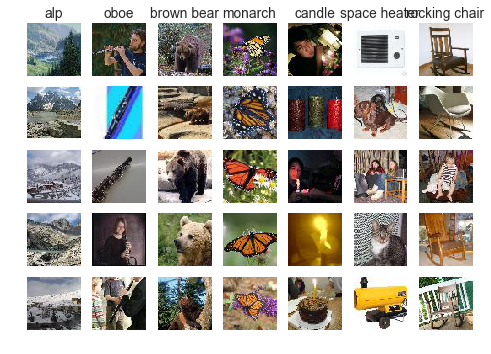

In [4]:
# Visualize some examples of the training data
classes_to_show = 7
examples_per_class = 5

class_idxs = np.random.choice(len(class_names), size=classes_to_show, replace=False)
for i, class_idx in enumerate(class_idxs):
    train_idxs, = np.nonzero(y_train == class_idx)
    train_idxs = np.random.choice(train_idxs, size=examples_per_class, replace=False)
    for j, train_idx in enumerate(train_idxs):
        img = X_train[train_idx] + mean_img
        img = img.transpose(1, 2, 0).astype('uint8')
        plt.subplot(examples_per_class, classes_to_show, 1 + i + classes_to_show * j)
        if j == 0:
            plt.title(class_names[class_idx][0])
        plt.imshow(img)
        plt.gca().axis('off')

plt.show()

# Test human performance
Run the following to test your own classification performance on the TinyImageNet-100-A dataset.

You can run several times in 'training' mode to get familiar with the task; once you are ready to test yourself, switch the mode to `'val'`.

You won't be penalized if you don't correctly classify all the images, but you should still try your best.

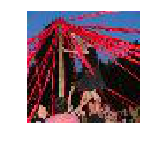

Guess the class for the above image (1 / 10) : maypole
Correct!


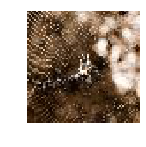

Guess the class for the above image (2 / 10) : spider's web
Correct!


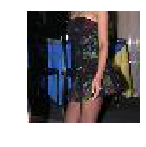

Guess the class for the above image (3 / 10) : miniskirt
Correct!


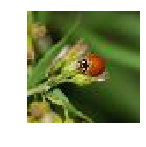

Guess the class for the above image (4 / 10) : ladybug
Correct!


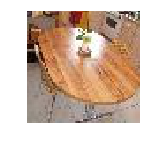

Guess the class for the above image (5 / 10) : dining table
Correct!


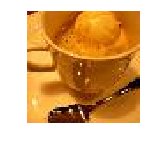

Guess the class for the above image (6 / 10) : espresso
Correct!


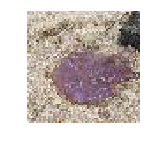

Guess the class for the above image (7 / 10) : rock lobster
Incorrect; it was actually ['jellyfish']


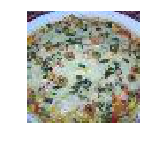

Guess the class for the above image (8 / 10) : pizza
Correct!


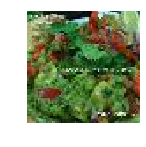

Guess the class for the above image (9 / 10) : European fire salamander
Incorrect; it was actually ['guacamole']


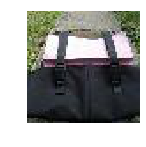

Guess the class for the above image (10 / 10) : birdhouse
Incorrect; it was actually ['backpack', 'back pack', 'knapsack', 'packsack', 'rucksack', 'haversack']
You got 7 / 10 correct for an accuracy of 0.700000


In [5]:
mode = 'val'

name_to_label = {n.lower(): i for i, ns in enumerate(class_names) for n in ns}

if mode == 'train':
    X, y = X_train, y_train
elif mode == 'val':
    X, y = X_val, y_val
    
num_correct = 0
num_images = 10
for i in range(num_images):
    idx = np.random.randint(X.shape[0])
    img = (X[idx] + mean_img).transpose(1, 2, 0).astype('uint8')
    plt.imshow(img)
    plt.gca().axis('off')
    plt.gcf().set_size_inches((2, 2))
    plt.show()
    got_name = False
    while not got_name:
        name = input('Guess the class for the above image (%d / %d) : ' % (i + 1, num_images))
        name = name.lower()
        got_name = name in name_to_label
        if not got_name:
            print( 'That is not a valid class name; try again')
    guess = name_to_label[name]
    if guess == y[idx]:
        num_correct += 1
        print( 'Correct!')
    else:
        print( 'Incorrect; it was actually %r' % class_names[y[idx]])

acc = float(num_correct) / num_images
print( 'You got %d / %d correct for an accuracy of %f' % (num_correct, num_images, acc))

# Download pretrained models
We have provided 10 pretrained ConvNets for the TinyImageNet-100-A dataset. Each of these models is a five-layer ConvNet with the architecture

[conv - relu - pool] x 3 - affine - relu - affine - softmax

All convolutional layers are 3x3 with stride 1 and all pooling layers are 2x2 with stride 2. The first two convolutional layers have 32 filters each, and the third convolutional layer has 64 filters. The hidden affine layer has 512 neurons. You can run the forward and backward pass for these five layer convnets using the function `five_layer_convnet` in the file `cs231n/classifiers/convnet.py`.

Each of these models was trained for 25 epochs over the TinyImageNet-100-A training data with a batch size of 50 and with dropout on the hidden affine layer. Each model was trained using slightly different values for the learning rate, regularization, and dropout probability.

To download the pretrained models, go into the `cs231n/datasets` directory and run the `get_pretrained_models.sh` script. Once you have done so, run the following to load the pretrained models into memory.

NOTE: The pretrained models will take about 245MB of disk space.

In [6]:
from cs231n.data_utils import load_models

models_dir = 'cs231n/datasets/tiny-100-A-pretrained'

# models is a dictionary mappping model names to models.
# Like the previous assignment, each model is a dictionary mapping parameter
# names to parameter values.
models = load_models(models_dir)

# Run models on the validation set
To benchmark the performance of each model on its own, we will use each model to make predictions on the validation set.

In [7]:
from cs231n.classifiers.convnet import five_layer_convnet

# Dictionary mapping model names to their predicted class probabilities on the
# validation set. model_to_probs[model_name] is an array of shape (N_val, 100)
# where model_to_probs[model_name][i, j] = p indicates that models[model_name]
# predicts that X_val[i] has class i with probability p.
model_to_probs = {}

################################################################################
# TODO: Use each model to predict classification probabilities for all images  #
# in the validation set. Store the predicted probabilities in the              #
# model_to_probs dictionary as above. To compute forward passes and compute    #
# probabilities, use the function five_layer_convnet in the file               #
# cs231n/classifiers/convnet.py.                                               #
#                                                                              #
# HINT: Trying to predict on the entire validation set all at once will use a  #
# ton of memory, so you should break the validation set into batches and run   #
# each batch through each model separately.                                    #
################################################################################
X_val_test = X_val[0:500]

chunk_size = 500
batch_list_X_val = [X_val[i:i+chunk_size] for i in range(0,X_val.shape[0],chunk_size)]

for key,model in models.items():
    p = []
    for x in batch_list_X_val:
        p.append(five_layer_convnet(x, model, y=None, reg=0.0, dropout=0., 
                                    extract_features=False, compute_dX=False, return_probs=True))
    model_to_probs[key] = np.concatenate(p,axis=0)
    
################################################################################
#                            END OF YOUR CODE                                  #
################################################################################    

# Compute and print the accuracy for each model.
for model_name, probs in model_to_probs.items():
    acc = np.mean(np.argmax(probs, axis=1) == y_val)
    print( '%s got accuracy %f' % (model_name, acc))

model1 got accuracy 0.371800
model5 got accuracy 0.368600
model4 got accuracy 0.369200
model7 got accuracy 0.360000
model9 got accuracy 0.358400
model3 got accuracy 0.370600
model2 got accuracy 0.371000
model6 got accuracy 0.363400
model10 got accuracy 0.357000
model8 got accuracy 0.357000


# Use a model ensemble
A simple way to implement an ensemble of models is to average the predicted probabilites for each model in the ensemble.

More concretely, suppose we have models $k$ models $m_1,\ldots,m_k$ and we want to combine them into an ensemble. If $p(x=y_i \mid m_j)$ is the probability that the input $x$ is classified as $y_i$ under model $m_j$, then the enemble predicts

$$p(x=y_i \mid \{m_1,\ldots,m_k\}) = \frac1k\sum_{j=1}^kp(x=y_i\mid m_j)$$

In the cell below, implement this simple ensemble method by filling in the `compute_ensemble_preds` function. The ensemble of all 10 models should perform much better than the best individual model.

In [8]:
def compute_ensemble_preds(probs_list):
    """
    Use the predicted class probabilities from different models to implement
    the ensembling method described above.
    
    Inputs:
    - probs_list: A list of numpy arrays, where each gives the predicted class
      probabilities under some model. In other words,
      probs_list[j][i, c] = p means that the jth model in the ensemble thinks
      that the ith data point has class c with probability p.
    
    Returns:
    An array y_pred_ensemble of ensembled predictions, such that
    y_pred_ensemble[i] = c means that ensemble predicts that the ith data point
    is predicted to have class c.
    """
    y_pred_ensemble = None
    ############################################################################
    # TODO: Implement this function. Store the ensemble predictions in         #
    # y_pred_ensemble.                                                         #
    ############################################################################
    mean_probs = np.mean(probs_list[:],axis=0)
    y_pred_ensemble = np.argmax(mean_probs, axis=1)
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    return y_pred_ensemble
    
# Combine all models into an ensemble and make predictions on the validation set.
# This should be significantly better than the best individual model.
print( np.mean(compute_ensemble_preds(list(model_to_probs.values())) == y_val))

0.4244


# Ensemble size vs Performance
Using our 10 pretrained models, we can form many different ensembles of different sizes. More precisely, if we have $n$ models and we want to form an ensemble of $k$ models, then there are $\binom{n}{k}$ possible ensembles that we can form, where

$$\binom{n}{k} = \frac{n!}{(n-k)!k!}$$

We can use these different possible ensembles to study the effect of ensemble size on ensemble performance.

In the cell below, compute the validation set accuracy of all possible ensembles of our 10 pretrained models. Produce a scatter plot with "ensemble size" on the horizontal axis and "validation set accuracy" on the vertical axis. Your plot should have a total of

$$\sum_{k=1}^{10} \binom{10}{k}$$

points corresponding to all possible ensembles of the 10 pretrained models.

You should be able to compute the validation set predictions of these ensembles without computing any more forward passes through any of the networks.

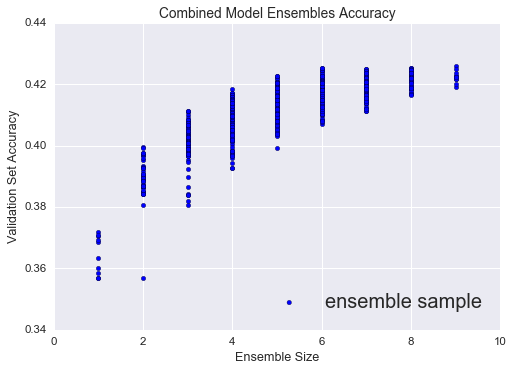

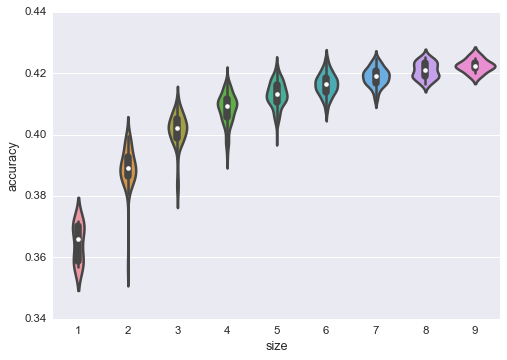

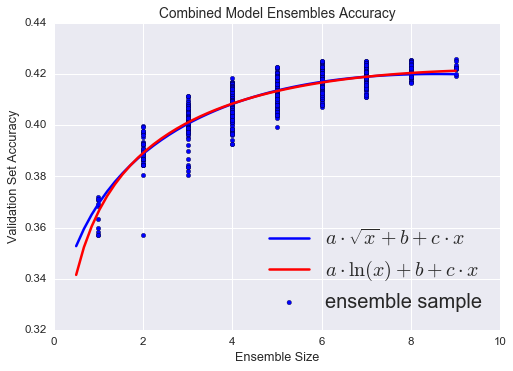

In [9]:
################################################################################
# TODO: Create a plot comparing ensemble size with ensemble performance as     #
# described above.                                                             #
#                                                                              #
# HINT: Look up the function itertools.combinations.                           #
################################################################################
from itertools import combinations
models_ = list(model_to_probs.values())

ensemble_sizes = []
validation_accuracies = []
ensemble_dict = {}
for l in range(1,10):
    ensemble_dict[l] = []
    for comb in combinations(models_, l):
        ensemble_sizes.append(l)
        accuracy = np.mean(compute_ensemble_preds(comb) == y_val)
        validation_accuracies.append(accuracy)
        ensemble_dict[l].append(accuracy)
        
ax1 = plt.scatter(ensemble_sizes, validation_accuracies, label='ensemble sample')
plt.title('Combined Model Ensembles Accuracy')
plt.xlabel('Ensemble Size')
plt.ylabel('Validation Set Accuracy')
plt.legend(loc='lower right', prop={'size':20})


#regression plot?

fig1 = plt.figure()
ensemble_series = pd.Series(ensemble_sizes, name='size')
accuracy_series = pd.Series(validation_accuracies, name='accuracy')
df = pd.concat([ensemble_series,accuracy_series], axis=1)
#df = pd.DataFrame([ensemble_sizes, validation_accuracies], ['ensemble_size', 'accuracy'])
#print(df.head())
sns.violinplot(x='size', y='accuracy',data=df)
#sns.violinplot(x=ensemble_sizes, y=accuracy)

from scipy.optimize import curve_fit

def fit_func(x, a, b, c):
    return a * np.sqrt(x) + b + c*x

def fit_func_log(x,a,b,c):
    return a * np.log(x) + b + c*x

popt, pcov = curve_fit(fit_func, ensemble_sizes, validation_accuracies, check_finite=True)
popt_l, pcov_l = curve_fit(fit_func_log, ensemble_sizes, validation_accuracies, check_finite=True)


fig2 = plt.figure()
#print(popt)
#print(popt_l)
x = np.linspace(0.5,9,50)
y = fit_func(x,*popt)
y_l = fit_func_log(x, *popt_l)
plt.plot(x,y,"b",label=r"$a\cdot\sqrt{x} + b + c\cdot x$")
plt.plot(x,y_l,"r", label=r"$a\cdot\ln{(x)} + b + c\cdot x$")
plt.legend(loc='lower right', prop={'size':20})

plt.scatter(ensemble_sizes, validation_accuracies, label='ensemble sample')
plt.title('Combined Model Ensembles Accuracy')
plt.xlabel('Ensemble Size')
plt.ylabel('Validation Set Accuracy')
plt.legend(loc='lower right', prop={'size':20})

################################################################################
#                            END OF YOUR CODE                                  #
################################################################################

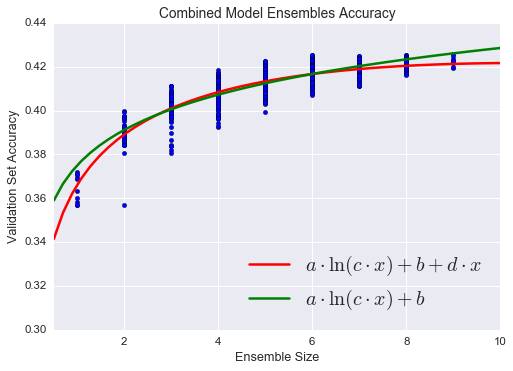

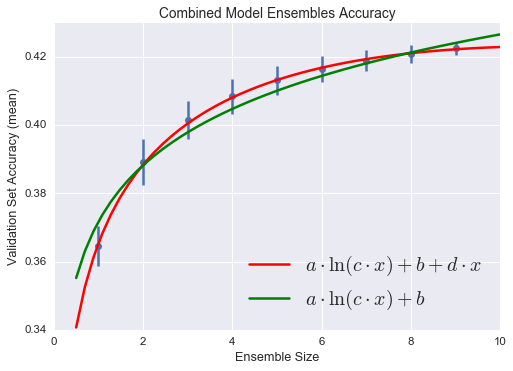

In [10]:
plt.figure()
sizes      = np.array(ensemble_sizes)
accuracies = np.array(validation_accuracies)

unique_sizes = np.unique(sizes)
#print(unique_sizes)
idx = np.where(sizes == 1)
#print(np.mean(accuracies[idx]))
#print(idx)

idx_2 = np.where(sizes==2)
#print(np.mean(accuracies[idx_2]))

t = unique_sizes
y = []
sigma = []
for x in unique_sizes:
    y.append(np.mean(accuracies[np.where(sizes == x)]))
    sigma.append(np.std(accuracies[np.where(sizes == x)]))

def fit_func_log(x,a,b,c,d):
    return a * np.log(c * x) + b + d * x

def fit_func_log_1(x,a,b,c):
    return a * np.log(c * x) + b

popt, pcov = curve_fit(fit_func_log, ensemble_sizes, validation_accuracies, check_finite=True)
popt_l, pcov_l = curve_fit(fit_func_log_1, ensemble_sizes, validation_accuracies, check_finite=True)

plt.scatter(ensemble_sizes, validation_accuracies)

plt.title('Combined Model Ensembles Accuracy')
plt.xlabel('Ensemble Size')
plt.ylabel('Validation Set Accuracy')
#plt.plot(t,y)
t_int = np.linspace(0.5,10,50)
plt.plot(t_int, fit_func_log(t_int,*popt), color='r', label=r"$a\cdot\ln({c\cdot x}) + b + d\cdot x$")
plt.plot(t_int, fit_func_log_1(t_int, *popt_l), color='g', label=r"$a\cdot\ln({c\cdot x}) + b$")
plt.xlim([0.5, 10])
plt.ylim([0.3, 0.44])
plt.legend(loc='lower right', prop={'size':20})

#plt.plot(t_int, fit_func(t_int,*popt_l))

popt_m_l,   pcov_m_l = curve_fit(fit_func_log, t, np.array(y), sigma=sigma, check_finite=True)
popt_m_l_1, pcov_m_l_1 = curve_fit(fit_func_log_1, t, np.array(y), sigma=sigma, check_finite=True)

#print(popt_l)
plt.figure()
plt.errorbar(unique_sizes, np.array(y), yerr=sigma, fmt='o')
plt.xlim([0,10])
plt.plot(t_int, fit_func_log(t_int,*popt_m_l), color='r', label=r"$a\cdot\ln({c\cdot x}) + b + d\cdot x$")
plt.plot(t_int, fit_func_log_1(t_int, *popt_m_l_1), color='g', label=r"$a\cdot\ln({c\cdot x}) + b$")
plt.title('Combined Model Ensembles Accuracy')
plt.xlabel('Ensemble Size')
plt.ylabel('Validation Set Accuracy (mean)')
plt.legend(loc='lower right', prop={'size':20})

In [11]:
#THIS DOESN'T appear to work

# from cs231n.layers import softmax_loss

# # #all probabilities are stored in list: models_
# # z = [1 + 0.2 * np.random.normal(size=(1,1)).flatten()[0] for x in models_]
# # z = np.array(z)
# # z = z[:,np.newaxis,np.newaxis]
# # tmp = np.array(models_)
# # summed_ensemble = np.sum(np.multiply(tmp,z),axis=0)

# # loss, dscore = softmax_loss(summed_ensemble, y_val)
# # print(loss,dscore.shape)

# # #dscore.dot(summed_ensemble.T)
# # dlambda = []
# # for i in tmp:
# #     dlambda.append(dscore.dot(i.T))

# # print(np.sum(dlambda[0]))

# z = np.array([10 + 2 * np.random.normal(size=(1,1)).flatten()[0] for x in models_])
# z = z[:,np.newaxis,np.newaxis]
# weighted_ensemble = z * np.array(models_)
# #print(z)

# weighted_sum = np.sum(weighted_ensemble, axis=0)
# loss, dscore = softmax_loss(weighted_sum, y_val)

# dlambda = np.zeros_like(z)

# dlambda[:] = np.sum(dscore.dot(weighted_sum[:].T))


# learning_rate = 0.05

# for i in range(20000):
#     weighted_ensemble = z * np.array(models_)
#     #size 3 for now
#     weighted_sum = np.sum(weighted_ensemble, axis=0)
#     loss, dscore = softmax_loss(weighted_sum, y_val)
    
#     for j in np.arange(weighted_ensemble.shape[0]):
#         dlambda[j] = np.sum(dscore.dot(weighted_ensemble[j].T))
    
#     # We are minimizing the loss so:
#     z += - learning_rate * dlambda
#     if i % 50 == 0:
#         print("iteration %d, loss %g, validation acc %g" % (i, loss, np.mean(compute_ensemble_preds(weighted_ensemble) == y_val)))
